In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:2px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:10pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:11pt;padding:4px;}
table.dataframe{font-size:10px;}
</style>
"""))

In [12]:
import pandas as pd
import numpy as np
import sys
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 데이터 셋
from tensorflow.keras.utils import to_categorical  # 원핫인코딩
from tensorflow.keras.models import Sequential,save_model, load_model 
from tensorflow.keras.layers import Input, Dense, Dropout
from matplotlib import pyplot as plt # loss와 acc의 학습 과정 그래프
from sklearn.metrics import confusion_matrix # 혼동행렬
from sklearn.preprocessing import MinMaxScaler, StandardScaler # 스케일 조정
from sklearn.model_selection import train_test_split  # 데이터 분리

In [26]:
df = pd.read_csv('목적별_국적별_결측치.csv', comment='#', encoding='utf-8')
cols = [
    'country_kr', 'country_en', 
    'purpose_kr', 'purpose_en','ym','country_code', 'purpose_code',
     'year', 'month',
    'is_peak', 'lag_1', 'rolling_mean_3',
    'visitors'
]
df = df[cols]

X = df.iloc[:, 5:-1].values
y = df.iloc[:, -1].values
X.shape, y.shape

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                   y,
                                                   test_size=0.3, # 테스트셋비율
                                                   random_state=7,
                                                
                                                   )

X_train.shape, X_test.shape, y_train.shape, y_test.shape



((16870, 7), (7231, 7), (16870,), (7231,))

In [32]:
model = Sequential()
model.add(Input(shape=(11,)))
model.add(Dense(units=300, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=400, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=200, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 300)               3600      
                                                                 
 dense_6 (Dense)             (None, 400)               120400    
                                                                 
 dense_7 (Dense)             (None, 200)               80200     
                                                                 
 dense_8 (Dense)             (None, 10)                2010      
                                                                 
Total params: 206,210
Trainable params: 206,210
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(loss='categorical_crossentropy',  # sparse_categorical_crossentropy 원핫인코딩 안할때
             optimizer='adam',
             metrics=['accuracy'])

In [34]:
hist = model.fit(X_train,y_train,
                epochs=100,
                batch_size=100,
                validation_split=(0.2),
                verbose=1)

Epoch 1/100


ValueError: in user code:

    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 11), found shape=(None, 7)


In [39]:

# ✅ LSTM 4개 Feature 버전 - 깔끔 주석 포함

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1️⃣ 데이터 로드
df = pd.read_csv('목적별_국적별_결측치.csv')

# 2️⃣ 결측치 처리
df = df.fillna(method='ffill')
df = df.sort_values(['country_code', 'purpose_code', 'year', 'month'])

# 3️⃣ Feature 4개만 사용
features = ['visitors', 'lag_1', 'rolling_mean_3', 'is_peak']

# 4️⃣ 스케일링
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

# 5️⃣ Sliding Window
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps, 0])  # visitors_num
    return np.array(X), np.array(y)

n_steps = 12
X, y = create_sequences(scaled, n_steps)

print(f'X Shape: {X.shape}')
print(f'y Shape: {y.shape}')

# 6️⃣ LSTM
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=50, batch_size=32)

# 7️⃣ 예측
y_pred = model.predict(X)
y_pred_inv = scaler.inverse_transform(
    np.hstack([y_pred, np.zeros((len(y_pred), len(features)-1))])
)[:,0]

print('예측 샘플:', y_pred_inv[:5])

# 8️⃣ 저장
model.save('foreign_visitors_lstm_4features.h5')
print('✅ 4개 Feature LSTM 모델 저장 완료')


X Shape: (24089, 12, 4)
y Shape: (24089,)
Epoch 1/50
753/753 [==============================] - 5s 5ms/step - loss: 5.1924e-04
Epoch 2/50
753/753 [==============================] - 4s 5ms/step - loss: 3.0419e-04
Epoch 3/50
753/753 [==============================] - 4s 5ms/step - loss: 2.6027e-04
Epoch 4/50
753/753 [==============================] - 4s 6ms/step - loss: 2.2202e-04
Epoch 5/50
753/753 [==============================] - 4s 6ms/step - loss: 2.3926e-04
Epoch 6/50
753/753 [==============================] - 4s 6ms/step - loss: 2.2624e-04
Epoch 7/50
753/753 [==============================] - 4s 5ms/step - loss: 2.0327e-04
Epoch 8/50
753/753 [==============================] - 4s 5ms/step - loss: 2.1148e-04
Epoch 9/50
753/753 [==============================] - 4s 5ms/step - loss: 1.9283e-04
Epoch 10/50
753/753 [==============================] - 4s 5ms/step - loss: 1.9076e-04
Epoch 11/50
753/753 [==============================] - 4s 6ms/step - loss: 1.8812e-04
Epoch 12/50
753/753 [

In [55]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [54]:

# ✅ LSTM 학습 파이프라인 (Feature 4개 버전)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1️⃣ 데이터 로드
df = pd.read_csv('목적별_국적별_결측치.csv')
df = df.fillna(method='ffill')
df = df.sort_values(['country_code', 'purpose_code', 'year', 'month'])

# ✅ Feature 4개만 선택
features = ['visitors', 'lag_1', 'rolling_mean_3', 'is_peak']

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

# 2️⃣ Sliding Window
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 12
X, y = create_sequences(scaled, n_steps)

print(f"입력 Shape: {X.shape}")

# 3️⃣ LSTM 모델 (Feature 4개 버전)
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 4️⃣ 학습
model.fit(X, y, epochs=50, batch_size=32)

# 5️⃣ 모델 저장 (.h5)
model.save('foreign_visitors_lstm_model_4features.h5')
print('✅ Feature 4개 버전 LSTM 모델 저장 완료')


입력 Shape: (24089, 12, 4)
Epoch 1/50
549/753 [====================>.........] - ETA: 1s - loss: 4.8707e-04

KeyboardInterrupt: 

753/753 [==============================] - 2s 2ms/step


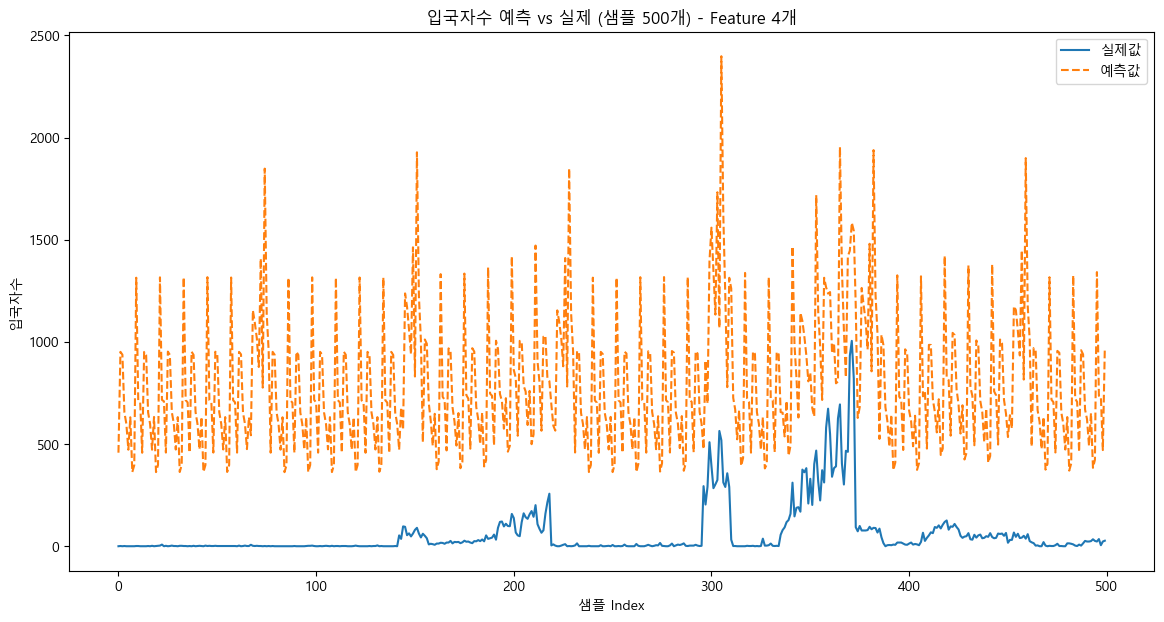

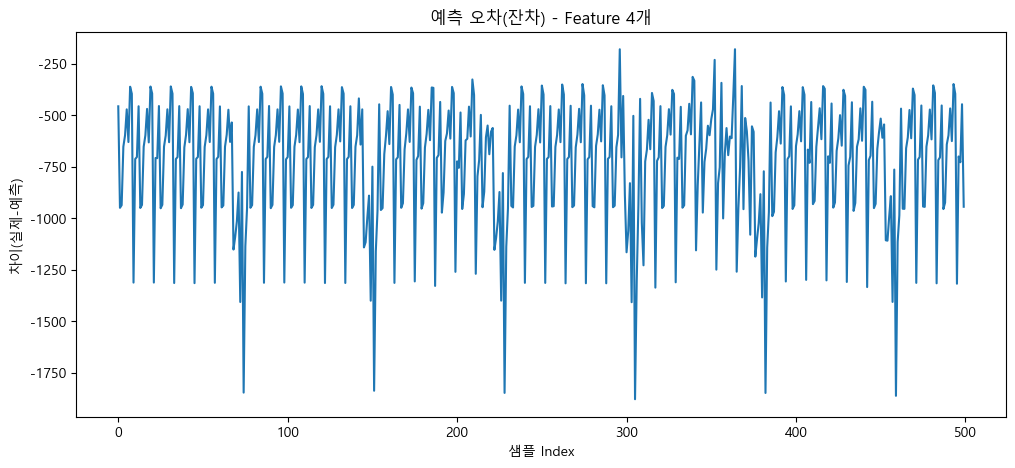

In [56]:

# ✅ LSTM 예측 결과 시각화 (Feature 4개 버전)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

# 1️⃣ 경로
csv_path = '목적별_국적별_결측치.csv'
model_path = 'foreign_visitors_lstm_model_4features.h5'

# 2️⃣ 파일 체크
assert os.path.exists(csv_path), f"CSV 파일 없음: {csv_path}"
assert os.path.exists(model_path), f"모델 없음: {model_path}"

# 3️⃣ 데이터 로드
df = pd.read_csv(csv_path)
df = df.fillna(method='ffill')
df = df.sort_values(['country_code', 'purpose_code', 'year', 'month'])

# ✅ Feature 4개만 선택
features = ['visitors', 'lag_1', 'rolling_mean_3', 'is_peak']

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

# 4️⃣ Sliding Window
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 12
X, y = create_sequences(scaled, n_steps)

# 5️⃣ 모델
model = load_model(model_path)

# 6️⃣ 예측
y_pred_scaled = model.predict(X)

# 7️⃣ 복원
y_pred_full = np.hstack([y_pred_scaled, np.zeros((len(y_pred_scaled), len(features)-1))])
y_pred_inv = scaler.inverse_transform(y_pred_full)[:,0]

# 8️⃣ 실제값 복원
y_true_full = np.hstack([y.reshape(-1,1), np.zeros((len(y), len(features)-1))])
y_true_inv = scaler.inverse_transform(y_true_full)[:,0]

# 9️⃣ 예측 vs 실제 그래프
plt.figure(figsize=(14,7))
plt.plot(y_true_inv[:500], label='실제값')
plt.plot(y_pred_inv[:500], label='예측값', linestyle='--')
plt.title('입국자수 예측 vs 실제 (샘플 500개) - Feature 4개')
plt.xlabel('샘플 Index')
plt.ylabel('입국자수')
plt.legend()
plt.show()

# 10️⃣ 잔차 그래프
residual = y_true_inv - y_pred_inv

plt.figure(figsize=(12,5))
plt.plot(residual[:500])
plt.title('예측 오차(잔차) - Feature 4개')
plt.xlabel('샘플 Index')
plt.ylabel('차이(실제-예측)')
plt.show()
